+-------------------+----------------------+
| Compression Ratio | Mean of Third Column |
+-------------------+----------------------+
|        0.1        |         27.5         |
|        0.2        |         31.7         |
|        0.3        |         32.7         |
|        0.4        |         32.9         |
|        0.5        |         34.7         |
|        0.6        |         33.3         |
|        0.7        |         33.6         |
|        0.8        |         34.7         |
|        0.9        |         35.5         |
+-------------------+----------------------+


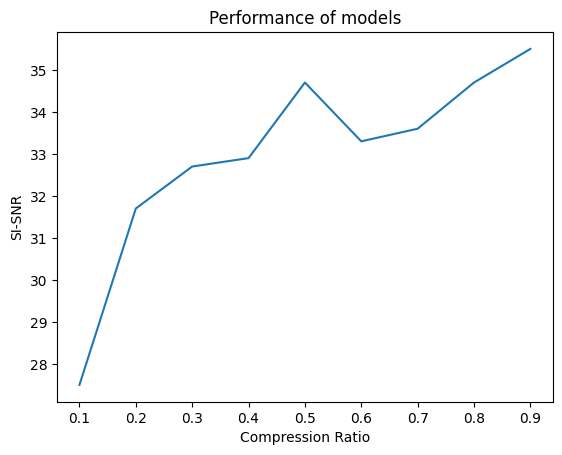

In [49]:
import csv
import os
import numpy as np
from prettytable import PrettyTable
import matplotlib.pyplot as plt
import seaborn as sns

inpathOut = "/home/martin/martin_user_data/jupyter_notebooks/autoencoder_ml/outputpdf/erster/"
fileNames = [filename for filename in os.listdir(inpathOut) if filename.endswith(".csv")]

results = []
for filename in fileNames:
    compression_ratio = float(filename.split(":")[1].split("Performance.csv")[0])
    mean_list = []
    with open(inpathOut + filename, "r") as file:
        csv_reader = csv.reader(file)
        for row in csv_reader:
            third_column_value = float(row[2])
            mean_list.append(third_column_value)

    mean = round(sum(mean_list) / len(mean_list), 1)
    results.append([compression_ratio, mean])

results = np.array(sorted(results, key=lambda x: x[0]))  # Sort based on compression ratio

table = PrettyTable()
table.field_names = ["Compression Ratio", "Mean of Third Column"]
for result in results:
    table.add_row(result)

print(table)

x = results[:, 0]
y = results[:, 1]

plt.plot(results[:,0], results[:,1])
plt.xlabel("Compression Ratio")
plt.ylabel("SI-SNR")
plt.title("Performance of models")
plt.show()


In [2]:
pip install numpy==1.24


/bin/bash: /home/martin/.local/anaconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Note: you may need to restart the kernel to use updated packages.


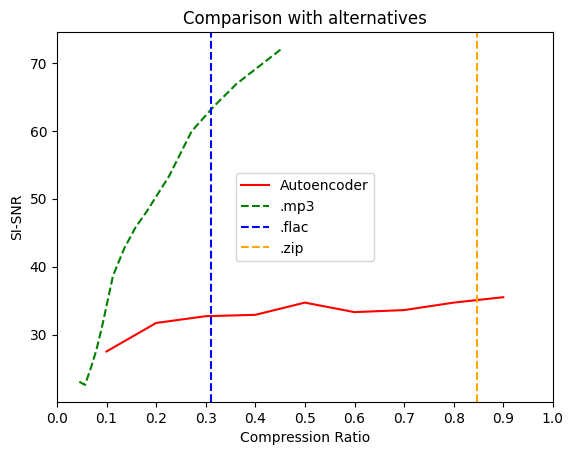

In [83]:
import numpy as np
import librosa
from scipy.io import wavfile

def calculate_sisnr(audio_path):
    # Load mp3 file
    estimate, _ = librosa.load(audio_path, sr=44100)

    # Split stereo audio to mono if needed
    if len(estimate.shape) > 1:
        estimate = estimate.mean(axis=1)
    
    # estimate = estimate.astype('int16')
    # print(estimate.dtype)

    # Load wav file
    fs, data = wavfile.read('2678_ps10_01.wav')
    if data.ndim > 1:
        mono_data = np.mean(data, axis=1)
    else:
        mono_data = data
    target = mono_data.astype('float32')

    estimate = estimate[:-3]
    # print(len(mono_data))
    # print(len(estimate))


    # estimate = np.array(estimate[:len(target)]).astype('int16')


    # estimate = estimate.astype('int16')

    # target and estimate are arrays of shape (batch_size, time_steps)
    # compute the dot product of target and estimate along the time axis
    dot = np.sum(target * estimate, axis=-1, keepdims=True)
    # compute the energy of target along the time axis
    energy = np.sum(target ** 2, axis=-1, keepdims=True)
    # compute the scaled target
    scaled_target = dot * target / energy
    # compute the noise
    noise = estimate - scaled_target
    # compute the SI-SNR in decibels
    si_snr = 10 * np.log10(np.sum(scaled_target ** 2, axis=-1) / np.sum(noise ** 2, axis=-1))
    # return the SI-SNR array of shape (batch_size,)
    return si_snr

# List of MP3 file paths

inpathOut = "/home/martin/martin_user_data/jupyter_notebooks/autoencoder_ml/"
mp3_files = [filename for filename in os.listdir(inpathOut) if filename.endswith(".mp3")]

# Calculate SI-SNR for each MP3 file
results_snr = []
for file in mp3_files:
    sisnr = calculate_sisnr(file)
    bitrate = float(file.split("01_")[1].split(".mp3")[0])
    compression_ratio = bitrate/707

    results_snr.append([compression_ratio, sisnr])

# results_snr = np.array(results_snr)
results_snr = np.array(sorted(results_snr, key=lambda x: x[0]))  # Sort based on compression ratio

# Print the SI-SNR results
# for i, sisnr in enumerate(results_snr):
#     print(f"SI-SNR for file {mp3_files[i]}: {sisnr[1]} SI-SNR")

# results_snr, results

plt.plot(results[:,0], results[:,1], label='Autoencoder', color='red')
plt.plot(results_snr[:,0], results_snr[:,1], label='.mp3', color='green', linestyle='--')
plt.axvline(x=10/32.2, color='blue', linestyle='--', label='.flac')
plt.axvline(x=27.3/32.2, color='orange', linestyle='--', label='.zip')
plt.xlabel("Compression Ratio")
plt.ylabel("SI-SNR")
plt.title("Comparison with alternatives")
# plt.xscale("log")
# plt.yscale("log")
xticks = np.linspace(0, 1, 11)
# yticks = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]  # Add more values if needed
plt.xticks(xticks)
plt.legend()
plt.savefig("SI-SNR_Comparison_all.pdf")

plt.show()
